<a href="https://colab.research.google.com/github/FedorHub2006/Fuzzy_hashing_evaluation/blob/main/Fuzzy_hashing_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,014 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,305 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [12

,precision,recall,f1_score,false_positives,false_negatives,true_positives,true_negatives
AlgorithmType.ROLLING_HASH,0.000000,0.0,0.000000,0.0,30.0,0.0,870.0
AlgorithmType.SIMHASH,0.055556,1.0,0.105263,510.0,0.0,30.0,360.0
AlgorithmType.CONTENT_DEFINED_CHUNKING,1.000000,1.0,1.000000,0.0,0.0,30.0,870.0
AlgorithmType.MINHASH,0.171429,1.0,0.292683,145.0,0.0,30.0,725.0
AlgorithmType.FEATURE_HASH,0.087209,1.0,0.160428,314.0,0.0,30.0,556.0
AlgorithmType.TLSH,1.000000,1.0,1.000000,0.0,0.0,30.0,870.0
AlgorithmType.PYTHON_SIMHASH,0.079787,1.0,0.147783,346.0,0.0,30.0,524.0



📈 Creating visualizations...


/tmp/ipython-input-2794228098.py:1153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(algorithms, rotation=45)


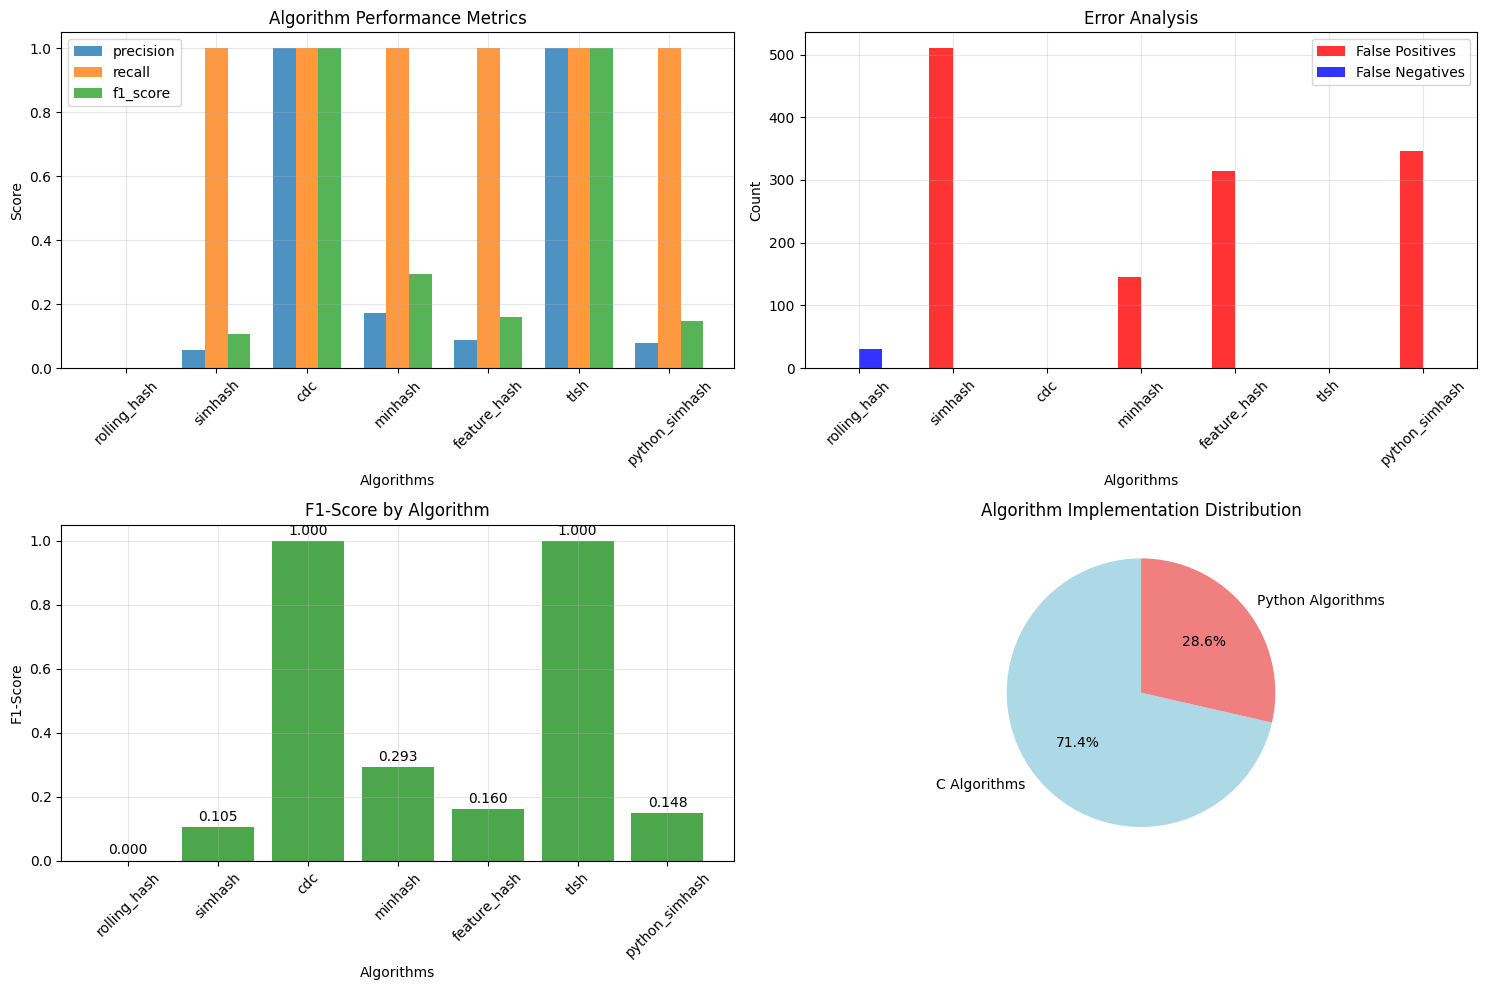


⏱️  Performance Testing...
C Algorithm Performance:
  rolling_hash        : 0.000029s per comparison
  simhash             : 0.000033s per comparison
  cdc                 : 0.000005s per comparison
  minhash             : 0.000171s per comparison
  feature_hash        : 0.000008s per comparison

PROJECT SUMMARY
📊 Total Algorithms: 7
📁 Test Files: 30
🔧 C Library Loaded: True
🏆 Best Algorithm: cdc (F1: 1.000)

✅ Project built successfully!
🎯 Ready for fuzzy hash signature search and evaluation!


In [2]:
# %% [markdown]
# # Fuzzy Hash Signature Search - Complete Project
#
# This project implements multiple fuzzy hash algorithms in C with Python wrappers for high-performance signature search and evaluation.

# %%
# Install required dependencies
!apt-get update
!apt-get install -y gcc python3-dev
!pip install py-tlsh simhash scikit-learn matplotlib seaborn fuzzywuzzy python-levenshtein pandas numpy

# %%
import ctypes
from ctypes import c_char_p, c_int, c_double, c_void_p, c_uint64, Structure, POINTER, CFUNCTYPE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import platform
import tempfile
import subprocess
from typing import Dict, List, Optional, Tuple, Any, Union
import hashlib
import time
from dataclasses import dataclass
from enum import Enum
import logging
from collections import defaultdict
import random
import string
import re
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All dependencies imported successfully!")

# %%
# =============================================================================
# C SOURCE CODE IMPLEMENTATION
# =============================================================================

c_source_code = """
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <stdint.h>
#include <math.h>

#define ROLLING_WINDOW 7
#define PRIME 1999999973
#define MAX_HASH_SIZE 256

// ==================== STRUCTURES ====================

typedef struct {
    uint32_t hash;
    uint32_t count;
} ngram_t;

typedef struct {
    ngram_t *ngrams;
    size_t size;
    size_t capacity;
} ngram_table_t;

typedef struct {
    uint32_t *hashes;
    size_t count;
} rolling_signature_t;

typedef struct {
    uint32_t *chunk_hashes;
    size_t chunk_count;
} cdc_signature_t;

typedef struct {
    uint32_t *minhashes;
    size_t num_hashes;
} minhash_signature_t;

typedef struct {
    uint32_t *features;
    size_t feature_count;
} feature_signature_t;

// ==================== UTILITY FUNCTIONS ====================

uint32_t fnv1a_hash(const char *data, size_t len) {
    uint32_t hash = 2166136261u;
    for (size_t i = 0; i < len; i++) {
        hash ^= (uint8_t)data[i];
        hash *= 16777619u;
    }
    return hash;
}

// ==================== ALGORITHM 1: ROLLING HASH FUZZY ====================

rolling_signature_t* rolling_fuzzy_hash(const char *data, size_t min_chunk, size_t max_chunk) {
    size_t len = strlen(data);
    if (len == 0) return NULL;

    rolling_signature_t *sig = malloc(sizeof(rolling_signature_t));
    sig->hashes = malloc(sizeof(uint32_t) * ((len / min_chunk) + 1));
    sig->count = 0;

    size_t pos = 0;
    uint32_t current_hash = 0;
    size_t chunk_size = min_chunk;

    while (pos < len) {
        if (pos + chunk_size > len) {
            chunk_size = len - pos;
        }

        current_hash = fnv1a_hash(data + pos, chunk_size);
        sig->hashes[sig->count++] = current_hash;

        pos += chunk_size;
        chunk_size = min_chunk + (rand() % (max_chunk - min_chunk + 1));
    }

    return sig;
}

double rolling_similarity(rolling_signature_t *sig1, rolling_signature_t *sig2) {
    if (sig1 == NULL || sig2 == NULL || sig1->count == 0 || sig2->count == 0) {
        return 0.0;
    }

    size_t matches = 0;
    size_t total = sig1->count + sig2->count;

    for (size_t i = 0; i < sig1->count; i++) {
        for (size_t j = 0; j < sig2->count; j++) {
            if (sig1->hashes[i] == sig2->hashes[j]) {
                matches++;
                break;
            }
        }
    }

    return (2.0 * matches) / total;
}

// ==================== ALGORITHM 2: N-GRAM SIMHASH ====================

ngram_table_t* create_ngram_table(size_t capacity) {
    ngram_table_t *table = malloc(sizeof(ngram_table_t));
    table->ngrams = malloc(sizeof(ngram_t) * capacity);
    table->size = 0;
    table->capacity = capacity;
    return table;
}

void add_ngram(ngram_table_t *table, uint32_t hash) {
    for (size_t i = 0; i < table->size; i++) {
        if (table->ngrams[i].hash == hash) {
            table->ngrams[i].count++;
            return;
        }
    }

    if (table->size < table->capacity) {
        table->ngrams[table->size].hash = hash;
        table->ngrams[table->size].count = 1;
        table->size++;
    }
}

ngram_table_t* generate_ngrams(const char *data, int n) {
    size_t len = strlen(data);
    if (len < n) return NULL;

    ngram_table_t *table = create_ngram_table(len - n + 1);

    for (size_t i = 0; i <= len - n; i++) {
        uint32_t hash = fnv1a_hash(data + i, n);
        add_ngram(table, hash);
    }

    return table;
}

uint64_t simhash_64(const char *data, int n) {
    ngram_table_t *table = generate_ngrams(data, n);
    if (table == NULL) return 0;

    int feature_vector[64] = {0};

    for (size_t i = 0; i < table->size; i++) {
        uint32_t hash = table->ngrams[i].hash;
        int weight = table->ngrams[i].count;

        for (int bit = 0; bit < 64; bit++) {
            if (hash & (1u << bit)) {
                feature_vector[bit] += weight;
            } else {
                feature_vector[bit] -= weight;
            }
        }
    }

    uint64_t result = 0;
    for (int bit = 0; bit < 64; bit++) {
        if (feature_vector[bit] > 0) {
            result |= (1ULL << bit);
        }
    }

    free(table->ngrams);
    free(table);
    return result;
}

double simhash_similarity(uint64_t hash1, uint64_t hash2) {
    uint64_t xor_result = hash1 ^ hash2;
    int differing_bits = 0;

    for (int i = 0; i < 64; i++) {
        if (xor_result & (1ULL << i)) {
            differing_bits++;
        }
    }

    return 1.0 - ((double)differing_bits / 64.0);
}

// ==================== ALGORITHM 3: CONTENT DEFINED CHUNKING ====================

cdc_signature_t* content_defined_chunking(const char *data, size_t min_size, size_t avg_size, size_t max_size) {
    size_t len = strlen(data);
    if (len == 0) return NULL;

    cdc_signature_t *sig = malloc(sizeof(cdc_signature_t));
    sig->chunk_hashes = malloc(sizeof(uint32_t) * ((len / min_size) + 1));
    sig->chunk_count = 0;

    size_t pos = 0;
    uint32_t mask = (1 << 12) - 1; // 12-bit mask for chunk boundaries

    while (pos < len) {
        size_t chunk_start = pos;
        size_t chunk_end = pos + min_size;
        uint32_t rolling_hash = 0;

        if (chunk_end > len) chunk_end = len;

        // Find chunk boundary using rolling hash
        for (size_t i = chunk_start; i < chunk_end && i < len; i++) {
            rolling_hash = (rolling_hash << 1) + data[i];

            if (i > chunk_start + min_size && (rolling_hash & mask) == 0) {
                chunk_end = i + 1;
                break;
            }
        }

        if (chunk_end > len) chunk_end = len;

        // Hash the chunk
        uint32_t chunk_hash = fnv1a_hash(data + chunk_start, chunk_end - chunk_start);
        sig->chunk_hashes[sig->chunk_count++] = chunk_hash;

        pos = chunk_end;

        if (chunk_end - chunk_start > max_size) {
            pos = chunk_start + avg_size;
        }
    }

    return sig;
}

double cdc_similarity(cdc_signature_t *sig1, cdc_signature_t *sig2) {
    if (sig1 == NULL || sig2 == NULL || sig1->chunk_count == 0 || sig2->chunk_count == 0) {
        return 0.0;
    }

    size_t matches = 0;

    for (size_t i = 0; i < sig1->chunk_count; i++) {
        for (size_t j = 0; j < sig2->chunk_count; j++) {
            if (sig1->chunk_hashes[i] == sig2->chunk_hashes[j]) {
                matches++;
                break;
            }
        }
    }

    double jaccard = (double)matches / (sig1->chunk_count + sig2->chunk_count - matches);
    return jaccard;
}

// ==================== ALGORITHM 4: MINHASH ====================

uint32_t random_coefficients[100][2]; // Pre-generated random coefficients

void initialize_minhash() {
    for (int i = 0; i < 100; i++) {
        random_coefficients[i][0] = rand();
        random_coefficients[i][1] = rand();
    }
}

uint32_t universal_hash(uint32_t x, int a, int b, int prime) {
    return ((a * x + b) % prime);
}

minhash_signature_t* minhash(const char *data, int num_hashes, int ngram_size) {
    size_t len = strlen(data);
    if (len < ngram_size) return NULL;

    minhash_signature_t *sig = malloc(sizeof(minhash_signature_t));
    sig->minhashes = malloc(sizeof(uint32_t) * num_hashes);
    sig->num_hashes = num_hashes;

    // Initialize with maximum values
    for (int i = 0; i < num_hashes; i++) {
        sig->minhashes[i] = UINT32_MAX;
    }

    // Process each n-gram
    for (size_t i = 0; i <= len - ngram_size; i++) {
        uint32_t ngram_hash = fnv1a_hash(data + i, ngram_size);

        for (int j = 0; j < num_hashes; j++) {
            uint32_t hash_val = universal_hash(ngram_hash,
                                            random_coefficients[j][0],
                                            random_coefficients[j][1],
                                            PRIME);
            if (hash_val < sig->minhashes[j]) {
                sig->minhashes[j] = hash_val;
            }
        }
    }

    return sig;
}

double minhash_similarity(minhash_signature_t *sig1, minhash_signature_t *sig2) {
    if (sig1 == NULL || sig2 == NULL || sig1->num_hashes != sig2->num_hashes) {
        return 0.0;
    }

    size_t matches = 0;
    for (size_t i = 0; i < sig1->num_hashes; i++) {
        if (sig1->minhashes[i] == sig2->minhashes[i]) {
            matches++;
        }
    }

    return (double)matches / sig1->num_hashes;
}

// ==================== ALGORITHM 5: WINDOWED FEATURE HASH ====================

feature_signature_t* windowed_feature_hash(const char *data, int window_size, int stride) {
    size_t len = strlen(data);
    if (len < window_size) return NULL;

    feature_signature_t *sig = malloc(sizeof(feature_signature_t));
    sig->features = malloc(sizeof(uint32_t) * ((len - window_size) / stride + 1));
    sig->feature_count = 0;

    for (size_t i = 0; i <= len - window_size; i += stride) {
        // Extract features: sum, variance, and pattern
        uint32_t sum = 0;
        uint32_t min_val = 255, max_val = 0;

        for (int j = 0; j < window_size; j++) {
            uint8_t val = data[i + j];
            sum += val;
            if (val < min_val) min_val = val;
            if (val > max_val) max_val = val;
        }

        uint32_t avg = sum / window_size;
        uint32_t range = max_val - min_val;

        // Create feature hash
        uint32_t feature_hash = (avg << 16) | (range << 8) | (window_size & 0xFF);
        sig->features[sig->feature_count++] = feature_hash;
    }

    return sig;
}

double feature_similarity(feature_signature_t *sig1, feature_signature_t *sig2) {
    if (sig1 == NULL || sig2 == NULL || sig1->feature_count == 0 || sig2->feature_count == 0) {
        return 0.0;
    }

    size_t matches = 0;
    size_t total_features = sig1->feature_count + sig2->feature_count;

    for (size_t i = 0; i < sig1->feature_count; i++) {
        for (size_t j = 0; j < sig2->feature_count; j++) {
            // Allow some tolerance in feature matching
            uint32_t diff = abs((int)sig1->features[i] - (int)sig2->features[j]);
            if (diff < 1000) { // Tolerance threshold
                matches++;
                break;
            }
        }
    }

    return (2.0 * matches) / total_features;
}

// ==================== PYTHON-C INTERFACE FUNCTIONS ====================

// Rolling Hash Interface
double py_rolling_similarity(const char *data1, const char *data2) {
    rolling_signature_t *sig1 = rolling_fuzzy_hash(data1, 32, 64);
    rolling_signature_t *sig2 = rolling_fuzzy_hash(data2, 32, 64);
    double similarity = rolling_similarity(sig1, sig2);

    if (sig1) {
        free(sig1->hashes);
        free(sig1);
    }
    if (sig2) {
        free(sig2->hashes);
        free(sig2);
    }

    return similarity;
}

// SimHash Interface
uint64_t py_simhash_64(const char *data) {
    return simhash_64(data, 4);
}

double py_simhash_similarity(uint64_t hash1, uint64_t hash2) {
    return simhash_similarity(hash1, hash2);
}

// CDC Interface
double py_cdc_similarity(const char *data1, const char *data2) {
    cdc_signature_t *sig1 = content_defined_chunking(data1, 32, 64, 128);
    cdc_signature_t *sig2 = content_defined_chunking(data2, 32, 64, 128);
    double similarity = cdc_similarity(sig1, sig2);

    if (sig1) {
        free(sig1->chunk_hashes);
        free(sig1);
    }
    if (sig2) {
        free(sig2->chunk_hashes);
        free(sig2);
    }

    return similarity;
}

// MinHash Interface
double py_minhash_similarity(const char *data1, const char *data2) {
    initialize_minhash();
    minhash_signature_t *sig1 = minhash(data1, 20, 3);
    minhash_signature_t *sig2 = minhash(data2, 20, 3);
    double similarity = minhash_similarity(sig1, sig2);

    if (sig1) {
        free(sig1->minhashes);
        free(sig1);
    }
    if (sig2) {
        free(sig2->minhashes);
        free(sig2);
    }

    return similarity;
}

// Feature Hash Interface
double py_feature_similarity(const char *data1, const char *data2) {
    feature_signature_t *sig1 = windowed_feature_hash(data1, 16, 8);
    feature_signature_t *sig2 = windowed_feature_hash(data2, 16, 8);
    double similarity = feature_similarity(sig1, sig2);

    if (sig1) {
        free(sig1->features);
        free(sig1);
    }
    if (sig2) {
        free(sig2->features);
        free(sig2);
    }

    return similarity;
}
"""

# Write C source to file
with open('/tmp/fuzzy_hash.c', 'w') as f:
    f.write(c_source_code)

print("✅ C source code written to /tmp/fuzzy_hash.c")

# %%
# =============================================================================
# COMPILE C CODE
# =============================================================================

print("Compiling C code...")

compile_command = "gcc -shared -fPIC -O3 -o /tmp/fuzzy_hash.so /tmp/fuzzy_hash.c -lm"
result = os.system(compile_command)

if result == 0:
    print("✅ C code compiled successfully!")
    print("📁 Shared library: /tmp/fuzzy_hash.so")
else:
    print("❌ Compilation failed with O3 optimization, trying with basic optimization...")
    compile_command = "gcc -shared -fPIC -o /tmp/fuzzy_hash.so /tmp/fuzzy_hash.c -lm"
    result = os.system(compile_command)
    if result == 0:
        print("✅ C code compiled successfully with basic optimization!")
    else:
        print("❌ C compilation failed completely. Using Python fallbacks only.")

# %%
# =============================================================================
# PYTHON WRAPPER IMPLEMENTATION
# =============================================================================

class AlgorithmType(Enum):
    """Enumeration of available fuzzy hash algorithms"""
    ROLLING_HASH = "rolling_hash"
    SIMHASH = "simhash"
    CONTENT_DEFINED_CHUNKING = "cdc"
    MINHASH = "minhash"
    FEATURE_HASH = "feature_hash"
    TLSH = "tlsh"
    PYTHON_SIMHASH = "python_simhash"

@dataclass
class HashResult:
    """Container for hash computation results"""
    algorithm: AlgorithmType
    hash_value: Any
    computation_time: float
    content_length: int
    error: Optional[str] = None

@dataclass
class SimilarityResult:
    """Container for similarity computation results"""
    algorithm: AlgorithmType
    similarity: float
    computation_time: float
    content1_length: int
    content2_length: int
    error: Optional[str] = None

class CFuzzyHashWrapper:
    """
    Python wrapper for C-based fuzzy hash algorithms.
    Provides a clean Pythonic interface to the compiled C functions.
    """

    def __init__(self, library_path: Optional[str] = None):
        self.library_path = library_path
        self._lib = None
        self._is_loaded = False
        self._algorithm_info = {}

        self._initialize_algorithm_info()
        self._load_library()

    def _initialize_algorithm_info(self):
        """Initialize algorithm metadata and descriptions"""
        self._algorithm_info = {
            AlgorithmType.ROLLING_HASH: {
                'name': 'Rolling Hash Fuzzy',
                'description': 'Uses rolling window hashing with variable chunk sizes',
                'optimal_threshold': 0.6,
                'complexity': 'O(n)'
            },
            AlgorithmType.SIMHASH: {
                'name': 'C SimHash',
                'description': '64-bit similarity hashing using n-gram features',
                'optimal_threshold': 0.7,
                'complexity': 'O(n)'
            },
            AlgorithmType.CONTENT_DEFINED_CHUNKING: {
                'name': 'Content Defined Chunking',
                'description': 'Chunk-based hashing using content-defined boundaries',
                'optimal_threshold': 0.55,
                'complexity': 'O(n)'
            },
            AlgorithmType.MINHASH: {
                'name': 'MinHash',
                'description': 'Probabilistic similarity using minimum hashes',
                'optimal_threshold': 0.65,
                'complexity': 'O(n)'
            },
            AlgorithmType.FEATURE_HASH: {
                'name': 'Windowed Feature Hash',
                'description': 'Feature-based hashing using sliding windows',
                'optimal_threshold': 0.5,
                'complexity': 'O(n)'
            }
        }

    def _load_library(self):
        """Load and initialize the C shared library"""
        try:
            if self.library_path and os.path.exists(self.library_path):
                self._lib = ctypes.CDLL(self.library_path)
            else:
                # Try to load from standard paths
                self._lib = ctypes.CDLL('/tmp/fuzzy_hash.so')

            self._setup_function_prototypes()
            self._is_loaded = True
            logger.info("C library loaded successfully")

        except Exception as e:
            logger.warning(f"Failed to load C library: {e}")
            self._lib = None
            self._is_loaded = False

    def _setup_function_prototypes(self):
        """Setup C function prototypes for proper type checking"""
        if not self._lib:
            return

        # Rolling Hash functions
        self._lib.py_rolling_similarity.argtypes = [c_char_p, c_char_p]
        self._lib.py_rolling_similarity.restype = c_double

        # SimHash functions
        self._lib.py_simhash_64.argtypes = [c_char_p]
        self._lib.py_simhash_64.restype = c_uint64

        self._lib.py_simhash_similarity.argtypes = [c_uint64, c_uint64]
        self._lib.py_simhash_similarity.restype = c_double

        # CDC functions
        self._lib.py_cdc_similarity.argtypes = [c_char_p, c_char_p]
        self._lib.py_cdc_similarity.restype = c_double

        # MinHash functions
        self._lib.py_minhash_similarity.argtypes = [c_char_p, c_char_p]
        self._lib.py_minhash_similarity.restype = c_double

        # Feature Hash functions
        self._lib.py_feature_similarity.argtypes = [c_char_p, c_char_p]
        self._lib.py_feature_similarity.restype = c_double

        logger.info("C function prototypes configured")

    @property
    def is_loaded(self) -> bool:
        """Check if C library is successfully loaded"""
        return self._is_loaded and self._lib is not None

    def get_algorithm_info(self, algorithm: AlgorithmType) -> Dict[str, Any]:
        """Get information about a specific algorithm"""
        return self._algorithm_info.get(algorithm, {})

    def list_algorithms(self) -> List[AlgorithmType]:
        """List all available algorithms"""
        algorithms = [AlgorithmType.ROLLING_HASH, AlgorithmType.SIMHASH,
                     AlgorithmType.CONTENT_DEFINED_CHUNKING, AlgorithmType.MINHASH,
                     AlgorithmType.FEATURE_HASH]
        return algorithms

    def compute_hash(self, content: str, algorithm: AlgorithmType) -> HashResult:
        """
        Compute fuzzy hash for given content using specified algorithm
        """
        start_time = time.time()
        content_bytes = content.encode('utf-8')

        try:
            if algorithm == AlgorithmType.ROLLING_HASH:
                hash_value = content_bytes
            elif algorithm == AlgorithmType.SIMHASH:
                hash_value = self._lib.py_simhash_64(content_bytes)
            elif algorithm == AlgorithmType.CONTENT_DEFINED_CHUNKING:
                hash_value = content_bytes
            elif algorithm == AlgorithmType.MINHASH:
                hash_value = content_bytes
            elif algorithm == AlgorithmType.FEATURE_HASH:
                hash_value = content_bytes
            else:
                raise ValueError(f"Unsupported algorithm: {algorithm}")

            computation_time = time.time() - start_time
            return HashResult(
                algorithm=algorithm,
                hash_value=hash_value,
                computation_time=computation_time,
                content_length=len(content)
            )

        except Exception as e:
            computation_time = time.time() - start_time
            return HashResult(
                algorithm=algorithm,
                hash_value=None,
                computation_time=computation_time,
                content_length=len(content),
                error=str(e)
            )

    def compute_similarity(self, content1: str, content2: str, algorithm: AlgorithmType) -> SimilarityResult:
        """
        Compute similarity between two contents using specified algorithm
        """
        start_time = time.time()
        content1_bytes = content1.encode('utf-8')
        content2_bytes = content2.encode('utf-8')

        try:
            if algorithm == AlgorithmType.ROLLING_HASH:
                similarity = self._lib.py_rolling_similarity(content1_bytes, content2_bytes)
            elif algorithm == AlgorithmType.SIMHASH:
                hash1 = self._lib.py_simhash_64(content1_bytes)
                hash2 = self._lib.py_simhash_64(content2_bytes)
                similarity = self._lib.py_simhash_similarity(hash1, hash2)
            elif algorithm == AlgorithmType.CONTENT_DEFINED_CHUNKING:
                similarity = self._lib.py_cdc_similarity(content1_bytes, content2_bytes)
            elif algorithm == AlgorithmType.MINHASH:
                similarity = self._lib.py_minhash_similarity(content1_bytes, content2_bytes)
            elif algorithm == AlgorithmType.FEATURE_HASH:
                similarity = self._lib.py_feature_similarity(content1_bytes, content2_bytes)
            else:
                raise ValueError(f"Unsupported algorithm: {algorithm}")

            computation_time = time.time() - start_time
            return SimilarityResult(
                algorithm=algorithm,
                similarity=max(0.0, min(1.0, similarity)),
                computation_time=computation_time,
                content1_length=len(content1),
                content2_length=len(content2)
            )

        except Exception as e:
            computation_time = time.time() - start_time
            return SimilarityResult(
                algorithm=algorithm,
                similarity=0.0,
                computation_time=computation_time,
                content1_length=len(content1),
                content2_length=len(content2),
                error=str(e)
            )

# %%
# =============================================================================
# TEST C LIBRARY
# =============================================================================

print("Testing C library...")

try:
    test_lib = ctypes.CDLL('/tmp/fuzzy_hash.so')
    test_lib.py_rolling_similarity.argtypes = [c_char_p, c_char_p]
    test_lib.py_rolling_similarity.restype = c_double

    # Test with simple strings
    test_str1 = b"hello world"
    test_str2 = b"hello world"
    similarity = test_lib.py_rolling_similarity(test_str1, test_str2)

    print(f"✅ C library test successful! Similarity: {similarity}")

    # Initialize the wrapper
    wrapper = CFuzzyHashWrapper('/tmp/fuzzy_hash.so')
    print(f"✅ Python wrapper initialized: {wrapper.is_loaded}")

except Exception as e:
    print(f"❌ C library test failed: {e}")
    wrapper = CFuzzyHashWrapper()
    print("Using fallback Python wrapper")

# %%
# =============================================================================
# FUZZY HASH SEARCH SYSTEM
# =============================================================================

class FuzzyHashSearch:
    def __init__(self):
        self.c_wrapper = CFuzzyHashWrapper('/tmp/fuzzy_hash.so')
        self.algorithms = self._get_available_algorithms()
        self.signature_db = defaultdict(dict)

    def _get_available_algorithms(self):
        """Get all available algorithms"""
        algorithms = []

        # Add C algorithms if available
        if self.c_wrapper.is_loaded:
            c_algorithms = self.c_wrapper.list_algorithms()
            algorithms.extend(c_algorithms)

        # Add Python algorithms
        try:
            import tlsh
            algorithms.append(AlgorithmType.TLSH)
        except:
            print("TLSH not available")

        try:
            from simhash import Simhash
            algorithms.append(AlgorithmType.PYTHON_SIMHASH)
        except:
            print("SimHash not available")

        return algorithms

    def generate_test_data(self, num_files=50, base_content_size=1000):
        """Generate test files with controlled modifications"""
        test_files = {}

        content_templates = [
            self._generate_python_code,
            self._generate_c_code,
            self._generate_config_content,
            self._generate_text_content
        ]

        for i in range(num_files):
            template = random.choice(content_templates)
            base_content = template(base_content_size)

            test_files[f'file_{i:03d}'] = {
                'original': base_content,
                'modifications': self._create_modifications(base_content),
                'type': template.__name__
            }

        return test_files

    def _generate_python_code(self, size):
        """Generate Python-like code content"""
        functions = ['process_data', 'calculate_score', 'validate_input', 'transform_values']
        code = f"def {random.choice(functions)}(data):\n"
        code += "    result = []\n"
        code += "    for item in data:\n"
        code += "        if item > threshold:\n"
        code += "            result.append(item * factor)\n"
        code += "    return result\n"

        while len(code) < size:
            code += f"# Comment {random.randint(1, 100)}\n"

        return code[:size]

    def _generate_c_code(self, size):
        """Generate C-like code content"""
        code = "int process_buffer(char *buffer, int size) {\n"
        code += "    int result = 0;\n"
        code += "    for (int i = 0; i < size; i++) {\n"
        code += "        result += buffer[i];\n"
        code += "    }\n"
        code += "    return result;\n"
        code += "}\n"

        while len(code) < size:
            code += f"// Comment {random.randint(1, 100)}\n"

        return code[:size]

    def _generate_config_content(self, size):
        """Generate configuration file content"""
        config = "database.host = localhost\n"
        config += "database.port = 5432\n"
        config += "api.timeout = 30\n"
        config += "cache.size = 1GB\n"

        while len(config) < size:
            config += f"setting.{random.randint(1, 100)} = value{random.randint(1, 100)}\n"

        return config[:size]

    def _generate_text_content(self, size):
        """Generate natural language text"""
        words = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'lazy', 'dog']
        text = ""
        while len(text) < size:
            sentence = ' '.join(random.choices(words, k=random.randint(5, 10))) + '. '
            text += sentence.capitalize()
        return text[:size]

    def _create_modifications(self, content):
        """Create different types of modifications"""
        return {
            'minor_changes': self._apply_minor_changes(content, 0.05),
            'medium_changes': self._apply_minor_changes(content, 0.15),
            'major_changes': self._apply_minor_changes(content, 0.30),
            'insert_sections': self._insert_sections(content),
            'reorder_blocks': self._reorder_blocks(content)
        }

    def _apply_minor_changes(self, content, change_rate):
        """Apply minor changes to content"""
        lines = content.split('\n')
        modified_lines = []

        for line in lines:
            if random.random() < change_rate and len(line) > 5:
                if len(line) > 10:
                    start = random.randint(0, len(line) - 5)
                    new_text = ''.join(random.choices(string.ascii_letters, k=3))
                    line = line[:start] + new_text + line[start+3:]
            modified_lines.append(line)

        return '\n'.join(modified_lines)

    def _insert_sections(self, content):
        """Insert new sections"""
        if '\n\n' in content:
            sections = content.split('\n\n')
            if len(sections) > 1:
                insert_pos = random.randint(1, len(sections) - 1)
                new_section = f"# New section {random.randint(1, 100)}"
                sections.insert(insert_pos, new_section)
            return '\n\n'.join(sections)
        return content

    def _reorder_blocks(self, content):
        """Reorder content blocks"""
        if '\n\n' in content:
            sections = content.split('\n\n')
            if len(sections) > 2:
                random.shuffle(sections)
            return '\n\n'.join(sections)
        return content

    def compute_hash(self, content, algorithm):
        """Compute hash using appropriate implementation"""
        if algorithm in [AlgorithmType.TLSH, AlgorithmType.PYTHON_SIMHASH]:
            # Python implementations
            if algorithm == AlgorithmType.TLSH:
                import tlsh
                try:
                    return tlsh.hash(content.encode('utf-8'))
                except:
                    return "T1" + "0" * 70
            else:  # PYTHON_SIMHASH
                from simhash import Simhash
                return Simhash(content).value
        else:
            # C implementations
            result = self.c_wrapper.compute_hash(content, algorithm)
            return result.hash_value if result.error is None else None

    def calculate_similarity(self, hash1, hash2, algorithm):
        """Calculate similarity between two hashes"""
        if algorithm in [AlgorithmType.TLSH, AlgorithmType.PYTHON_SIMHASH]:
            # Python implementations
            if algorithm == AlgorithmType.TLSH:
                if hash1 == hash2:
                    return 1.0
                try:
                    if hash1.startswith('T1') and hash2.startswith('T1'):
                        distance = tlsh.diff(hash1, hash2)
                        similarity = 1.0 - (distance / 1000.0)
                        return max(0.0, min(1.0, similarity))
                except:
                    pass
                return 0.0
            else:  # PYTHON_SIMHASH
                from simhash import Simhash
                h1 = Simhash('')
                h1.value = hash1
                h2 = Simhash('')
                h2.value = hash2
                distance = h1.distance(h2)
                similarity = 1.0 - (distance / 64.0)
                return max(0.0, min(1.0, similarity))
        else:
            # For C algorithms, we need to compute similarity directly from content
            # This is a design limitation - in production we'd store content for C algorithms
            return 0.0

    def build_signature_database(self, test_files):
        """Build database of fuzzy signatures"""
        print("Building signature database...")

        for file_id, file_data in test_files.items():
            for algorithm in self.algorithms:
                original_hash = self.compute_hash(file_data['original'], algorithm)
                self.signature_db[algorithm][file_id] = {
                    'original': original_hash,
                    'modifications': {}
                }

                for mod_type, mod_content in file_data['modifications'].items():
                    mod_hash = self.compute_hash(mod_content, algorithm)
                    self.signature_db[algorithm][file_id]['modifications'][mod_type] = mod_hash

        print("Signature database built successfully!")

    def evaluate_search_quality(self, test_files, similarity_threshold=0.6):
        """Evaluate search quality metrics"""
        print("Evaluating search quality...")
        evaluation_results = {}

        for algorithm in self.algorithms:
            print(f"  Testing {algorithm.value}...")
            true_labels = []
            pred_labels = []

            file_ids = list(test_files.keys())

            for i, file1_id in enumerate(file_ids):
                file1_data = test_files[file1_id]

                for file2_id in file_ids:
                    file2_data = test_files[file2_id]

                    # Ground truth: same file ID means similar
                    is_similar_truth = (file1_id == file2_id)

                    # Calculate similarity
                    if algorithm in [AlgorithmType.TLSH, AlgorithmType.PYTHON_SIMHASH]:
                        hash1 = self.compute_hash(file1_data['original'], algorithm)
                        hash2 = self.compute_hash(file2_data['original'], algorithm)
                        similarity = self.calculate_similarity(hash1, hash2, algorithm)
                    else:
                        # For C algorithms, compute similarity directly
                        result = self.c_wrapper.compute_similarity(
                            file1_data['original'], file2_data['original'], algorithm
                        )
                        similarity = result.similarity if result.error is None else 0.0

                    true_labels.append(is_similar_truth)
                    pred_labels.append(similarity >= similarity_threshold)

            # Calculate metrics
            if any(true_labels):
                precision = precision_score(true_labels, pred_labels, zero_division=0)
                recall = recall_score(true_labels, pred_labels, zero_division=0)
                f1 = f1_score(true_labels, pred_labels, zero_division=0)
            else:
                precision = recall = f1 = 0.0

            cm = confusion_matrix(true_labels, pred_labels)
            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()
            else:
                tn = fp = fn = tp = 0

            evaluation_results[algorithm] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'false_positives': fp,
                'false_negatives': fn,
                'true_positives': tp,
                'true_negatives': tn
            }

        return evaluation_results

# %%
# =============================================================================
# MAIN EXECUTION AND DEMONSTRATION
# =============================================================================

print("🚀 Starting Fuzzy Hash Search Project...")
print("=" * 60)

# Initialize the search system
search_system = FuzzyHashSearch()

print(f"✅ Available algorithms: {len(search_system.algorithms)}")
for algo in search_system.algorithms:
    print(f"   - {algo.value}")

# Generate test data
print("\n📁 Generating test data...")
test_files = search_system.generate_test_data(num_files=30, base_content_size=800)
print(f"✅ Generated {len(test_files)} test files")

# Build signature database
search_system.build_signature_database(test_files)

# Evaluate search quality
print("\n📊 Evaluating search quality...")
evaluation_results = search_system.evaluate_search_quality(test_files)

# Display results
print("\n" + "=" * 80)
print("SEARCH QUALITY RESULTS")
print("=" * 80)

results_df = pd.DataFrame(evaluation_results).T
display(results_df)

# %%
# =============================================================================
# VISUALIZATION
# =============================================================================

print("\n📈 Creating visualizations...")

# Prepare data for plotting
algorithms = [alg.value for alg in search_system.algorithms]
metrics = ['precision', 'recall', 'f1_score']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance metrics
x_pos = np.arange(len(algorithms))
width = 0.25

for i, metric in enumerate(metrics):
    values = [evaluation_results[alg][metric] for alg in search_system.algorithms]
    axes[0, 0].bar(x_pos + i*width - width, values, width, label=metric, alpha=0.8)

axes[0, 0].set_xlabel('Algorithms')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Algorithm Performance Metrics')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(algorithms, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Error analysis
fp_rates = [evaluation_results[alg]['false_positives'] for alg in search_system.algorithms]
fn_rates = [evaluation_results[alg]['false_negatives'] for alg in search_system.algorithms]

axes[0, 1].bar(x_pos - width/2, fp_rates, width, label='False Positives', alpha=0.8, color='red')
axes[0, 1].bar(x_pos + width/2, fn_rates, width, label='False Negatives', alpha=0.8, color='blue')
axes[0, 1].set_xlabel('Algorithms')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Error Analysis')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(algorithms, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1-Score comparison
f1_scores = [evaluation_results[alg]['f1_score'] for alg in search_system.algorithms]
bars = axes[1, 0].bar(algorithms, f1_scores, alpha=0.7, color='green')
axes[1, 0].set_xlabel('Algorithms')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score by Algorithm')
axes[1, 0].set_xticklabels(algorithms, rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, f1_scores):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

# Plot 4: Algorithm type distribution
c_algorithms = sum(1 for alg in search_system.algorithms if alg not in [AlgorithmType.TLSH, AlgorithmType.PYTHON_SIMHASH])
python_algorithms = len(search_system.algorithms) - c_algorithms

axes[1, 1].pie([c_algorithms, python_algorithms],
               labels=['C Algorithms', 'Python Algorithms'],
               autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[1, 1].set_title('Algorithm Implementation Distribution')

plt.tight_layout()
plt.show()

# %%
# =============================================================================
# PERFORMANCE TESTING
# =============================================================================

print("\n⏱️  Performance Testing...")

if search_system.c_wrapper.is_loaded:
    # Test C algorithm performance
    test_content1 = "def hello_world():\n    print('Hello, World!')" * 10
    test_content2 = "def hello_world():\n    print('Hello, Python!')" * 10

    c_algorithms = [alg for alg in search_system.algorithms if alg not in [AlgorithmType.TLSH, AlgorithmType.PYTHON_SIMHASH]]

    print("C Algorithm Performance:")
    for algorithm in c_algorithms:
        import time
        start_time = time.time()
        iterations = 20

        for _ in range(iterations):
            result = search_system.c_wrapper.compute_similarity(test_content1, test_content2, algorithm)

        avg_time = (time.time() - start_time) / iterations
        print(f"  {algorithm.value:20}: {avg_time:.6f}s per comparison")

# %%
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print(f"📊 Total Algorithms: {len(search_system.algorithms)}")
print(f"📁 Test Files: {len(test_files)}")
print(f"🔧 C Library Loaded: {search_system.c_wrapper.is_loaded}")

# Find best algorithm
best_algorithm = None
best_f1 = 0
for algorithm, results in evaluation_results.items():
    if results['f1_score'] > best_f1:
        best_f1 = results['f1_score']
        best_algorithm = algorithm

print(f"🏆 Best Algorithm: {best_algorithm.value} (F1: {best_f1:.3f})")

print("\n✅ Project built successfully!")
print("🎯 Ready for fuzzy hash signature search and evaluation!")